# FDA Reading Room 483 Analysis

In [1]:
from datetime import date
print("Script last ran on {}".format(date.today().strftime("%m/%d/%Y")))

Script last ran on 05/06/2021


In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import lxml
import html5lib 
from bs4 import BeautifulSoup
import janitor
import tempfile
import os # to get current opperating system

import cv2
from PIL import Image

# selenium functions
from selenium import webdriver
from selenium.webdriver.common.keys import Keys #allow  you to enter keystrokes into fields
from selenium.webdriver.support.ui import Select #allow you to select a dropdown item
from selenium.webdriver.support.ui import WebDriverWait #lets you modify a field before proceeding
from selenium.common.exceptions import NoSuchElementException 

## Step 1: Scrape Data Table and List of URLs to Form 483s from URL

__Establishment Types to Filter By__  
Outsourcing Facility, Producer of Sterile and Non Sterile Drug Products, Producer of Sterile Drug Products, Producer of Non Sterile Drug Products, Manufacturer

In [3]:
cwd = os.getcwd()
temp483pdf_filepath = cwd + '\\temp483pdf'
temp483images_filepath = cwd + '\\temp483images'

op = webdriver.ChromeOptions()
prefs = {"download.default_directory": temp483pdf_filepath,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
         "download.extensions_to_open": "applications/pdf",
        "plugins.always_open_pdf_externally": True}
#prefs2 = {"download.prompt_for_download": False,
#        "download.directory_upgrade": True,
#         "download.extensions_to_open": "applications/pdf",
#        "plugins.always_open_pdf_externally": True}
op.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome()

table class = lcsd-datatable--ora-foia-reading table table-bordered dataTable no footer dtr-inline

In [14]:
# use driver to open website
url = 'https://www.fda.gov/about-fda/office-regulatory-affairs/ora-foia-electronic-reading-room'
driver.get(url)

In [15]:
# utilize the filter box to select only 483s (value = 0)
select = Select(driver.find_element_by_css_selector('#lcds-datatable-filter--record-filter'))
select.select_by_visible_text("483")

In [21]:
# get the table headers
## read the datatable of page 1 for the sake of retrieving headers
datatable_xpath = '//*[@id="DataTables_Table_0"]'
records = driver.find_element_by_xpath(datatable_xpath)
records_innerhtml = records.get_attribute('innerHTML')
soup = BeautifulSoup(records_innerhtml, 'html.parser')
trs = soup.findAll('tr')
headers = []
for th in trs[0].findAll('th'):
    headers.append(th.text)
headers

# scrape all rows in each page of the paginated datatable
final_page = int(driver.find_element_by_xpath('//*[@id="DataTables_Table_0_paginate"]/ul/li[8]').text)
rows = []
for page in range(1, final_page + 1):
    
    datatable_xpath = '//*[@id="DataTables_Table_0"]'
    records = driver.find_element_by_xpath(datatable_xpath)
    records_innerhtml = records.get_attribute('innerHTML')
    soup = BeautifulSoup(records_innerhtml, 'html.parser')
    trs = soup.findAll('tr')
    
    for i in range(1, len(trs)):
        tds = []
        #page_rows = []
        for td in trs[i].findAll('td'):
            a = td.findAll('a')
            spans = td.findAll('span')
            inputs = td.findAll('input')
            ret = ""
            if len(a) != 0 or len(spans) != 0 or len(inputs) != 0:
                if len(a) != 0:
                    for link in a:
                        ret += link.text + ' - '+link['href']
                if len(spans) != 0:
                    for span in spans:
                        ret += span.text + ' - '+span['title']
                if len(inputs) != 0:
                    for inp in inputs:
                        if inp.has_attr('value'):
                            if inp.has_attr('type'):
                                if inp['type'] == 'hidden':
                                    ret += inp['value']
            else: 
                ret = td.text if td.text != '' and td.text != '\n' else "NaN"
            tds.append(ret)
        rows.append(tds)
        
    driver.find_element_by_xpath('//*[@id="DataTables_Table_0_next"]/a').click() #//*[@id="DataTables_Table_0_next"]/a
    #driver.find_element_by_class_name('paginate_button next').click()

len(rows)

1458

In [20]:
driver.find_element_by_xpath('//*[@id="DataTables_Table_0_next"]/a').click()
#driver.find_element_by_class_name('paginate_button next').click()

ElementClickInterceptedException: Message: element click intercepted: Element <a href="#" aria-controls="DataTables_Table_0" data-dt-idx="8" tabindex="0">...</a> is not clickable at point (857, 850). Other element would receive the click: <a href="" id="btn-top" class="btn btn-primary btn-top show">...</a>
  (Session info: chrome=90.0.4430.93)


In [22]:
df = pd.DataFrame(rows, columns = headers)
df[['Record Type', 'HREF']] = df['Record Type'].str.split(' - ', 1, expand = True)
df = df.clean_names()
df['pdf_url'] = 'https://www.fda.gov' + df['href']
df.head()

,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,04/20/2020,3015448605,Emergent Manufacturing Operations Baltimore LLC,483,Maryland,Contract Testing Laboratory,04/23/2021,/media/147884/download,https://www.fda.gov/media/147884/download
1,04/09/2020,3010536120,"Medical Center Pharmacy, Inc.",483,Tennessee,Producer of Sterile and Non Sterile Drug Products,07/01/2020,/media/139661/download,https://www.fda.gov/media/139661/download
2,04/06/2020,2016493,"CareFusion 303, Inc.",483,California,Medical Device Manufacturer,01/25/2021,/media/145402/download,https://www.fda.gov/media/145402/download
3,03/30/2020,3010490167,"Edge Pharma, LLC",483,Vermont,Outsourcing Facility,10/08/2020,/media/142470/download,https://www.fda.gov/media/142470/download
4,03/20/2020,3003240654,"Front Range Laboratories, Incorporated",483,Colorado,Contract Testing Laboratory,09/21/2020,/media/142134/download,https://www.fda.gov/media/142134/download


In [23]:
#list(df.groupby('establishment_type').size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).establishment_type)
relavent_establishment_types = ['Producer of Sterile Drug Products', 'Outsourcing Facility', 'Manufacturer', 'Drug Manufacturer',
                               'Compounding Pharmacy', 'Producer of Non Sterile Drug Products', 'Sterile Drug Manufacturer', 
                               'Pharmaceutical Manufacturer', 'Human Drug Manufacturer', 'Biological Drug Manufacturer', 
                               'Active Pharmaceutical Ingredient Manufacturer', 'Manufacturer and Repacker', 
                               'Active Pharmaceutical Ingredient & Finished Dosage Manufacturer', 'Biotech API Manufacturer',
                               'Finished Pharmaceutical Manufacturer']
# include cosmetics in this list
df2 = df[df['establishment_type'].isin(relavent_establishment_types)].reset_index()
df2['record_date'] = pd.to_datetime(df2['record_date'])
df2['publish_date'] = pd.to_datetime(df2['publish_date'])
df2.shape

(1033, 10)

In [24]:
df2

,index,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,3,2020-03-30,3010490167,"Edge Pharma, LLC",483,Vermont,Outsourcing Facility,2020-10-08,/media/142470/download,https://www.fda.gov/media/142470/download
1,8,2020-03-11,3015826069,"Vital Care of Dickson, LLC.",483,Tennessee,Producer of Sterile Drug Products,2020-11-20,/media/143857/download,https://www.fda.gov/media/143857/download
2,9,2020-03-06,3011887629,"Empower Clinic Services, LLC",483,Texas,Outsourcing Facility,2020-05-04,/media/137544/download,https://www.fda.gov/media/137544/download
3,11,2020-02-28,3013854204,Maitland Labs of Central Florida,483,Florida,Outsourcing Facility,2020-03-09,/media/135889/download,https://www.fda.gov/media/135889/download
4,12,2020-02-27,3011110195,VA New Jersey Health Care System,483,New Jersey,Producer of Sterile Drug Products,2020-05-04,/media/137552/download,https://www.fda.gov/media/137552/download
...,...,...,...,...,...,...,...,...,...,...
1028,1451,NaT,NaN,"South Coast Specialty Compounding, Inc.",483,California,Producer of Sterile Drug Products,2019-06-16,/media/116957/download,https://www.fda.gov/media/116957/download
1029,1452,NaT,NaN,"Transdermal Therapeutics, Inc.",483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/116828/download,https://www.fda.gov/media/116828/download
1030,1453,NaT,NaN,NaN,483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/89847/download,https://www.fda.gov/media/89847/download
1031,1454,NaT,NaN,"South Coast Specialty Compounding, Inc.",483,California,Producer of Sterile Drug Products,2019-03-22,/media/116612/download,https://www.fda.gov/media/116612/download


In [25]:
driver.quit()

## Step 2: Read each 483 PDF through an OCR machine into notebook

__Useful Links__  
https://towardsdatascience.com/extracting-text-from-scanned-pdf-using-pytesseract-open-cv-cd670ee38052  
https://stackoverflow.com/questions/43149534/selenium-webdriver-how-to-download-a-pdf-file-with-python  
https://stackoverflow.com/questions/46184239/extract-a-page-from-a-pdf-as-a-jpeg  (has a useful comment about making a pdf into one long JPEG)  

In [26]:
driver = webdriver.Chrome(options = op)

In [40]:
list_urls = list(df2.pdf_url)
test_pdf_url = df2.pdf_url[0]
test_record_reference = str(df2.company_name[0]) + " " + str(df2.record_date[1].strftime('%Y-%m-%d'))

In [ ]:
driver.get(test_pdf_url) # does succesfully download into the right folder
#for pdf in df2[:10].pdf_url:
#    driver.get(pdf)

In [45]:
#!pip install pdf2image 
from pdf2image import convert_from_path

pdf = temp483pdf_filepath + "\\" + "EdgePharma508ed.pdf" #"\WellsPharmacy508ed_0.pdf"

with tempfile.TemporaryDirectory() as temp_dir:
    pages = convert_from_path(pdf, 300, output_folder = temp_dir)
    i = 1
    
    for page in pages:
        if i < 10:
            pn = "0" + str(i)
        else: 
            pn = str(i)
        image_name = temp483images_filepath + "\\" + test_record_reference + " - Page " + str(pn) + " of " + str(len(pages)) + ".jpg"
        page.save(image_name, 'JPEG')
        i = i + 1

In [28]:
driver.quit()

#### Cropping and tidying images

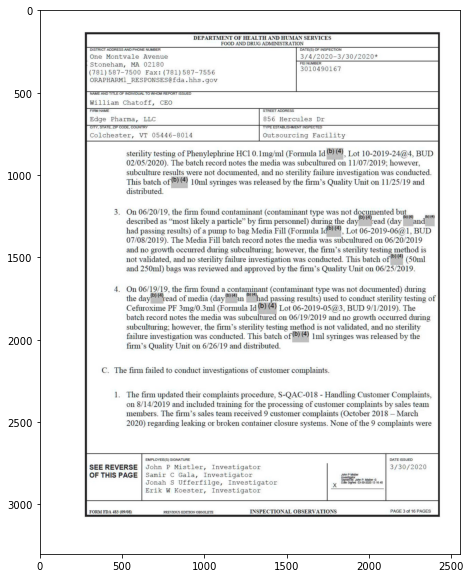

In [29]:
import pytesseract
test_image = temp483images_filepath + "\\" + "Edge Pharma, LLC 2020-03-11 - Page 03 of 17.jpg"
image = cv2.imread(test_image)

plt.figure(figsize=(10,10))
plt.imshow(image)

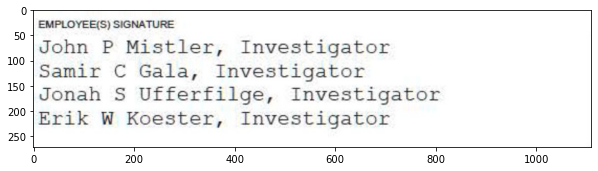

In [30]:
# list of auditors
auditors_coord = [(630, 2700), (1740, 2972)]
auditors = image[auditors_coord[0][1]:auditors_coord[1][1], auditors_coord[0][0]:auditors_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(auditors)
# convert the image to black and white for better OCR
#ret,thresh1 = cv2.threshold(img,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
#text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
#print(text)

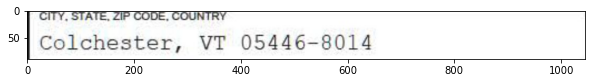

In [31]:
# city of facility
city_coord = [(280, 700), (1325, 790)]
facility_city = image[city_coord[0][1]:city_coord[1][1], city_coord[0][0]:city_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(facility_city)

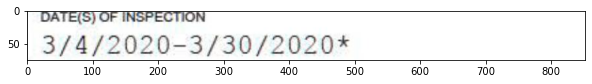

In [32]:
# date range of inspection
audit_dates_coord = [(1558, 230), (2410, 305)]
audit_dates = image[audit_dates_coord[0][1]:audit_dates_coord[1][1], audit_dates_coord[0][0]:audit_dates_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(audit_dates)

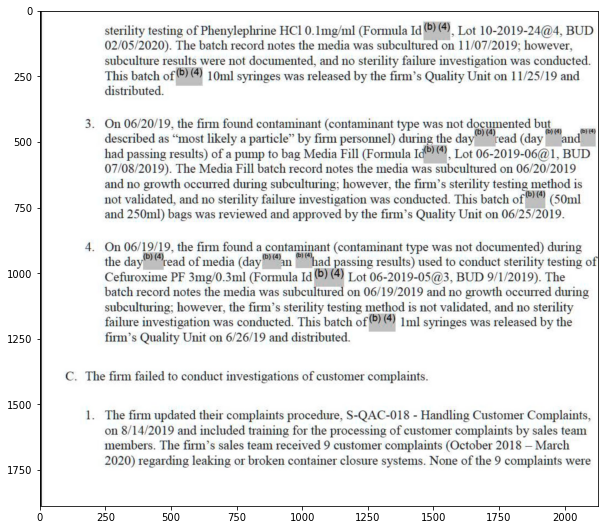

In [33]:
# observations
obs_coord = [(278, 793), (2405, 2680)]
observations = image[obs_coord[0][1]:obs_coord[1][1], obs_coord[0][0]:obs_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(observations)

In [ ]:
#from PIL import Image
#
#def convert_pdf_to_image(file_path, output_path):
#    # save temp image files in temp dir, delete them after we are finished
#    with tempfile.TemporaryDirectory() as temp_dir:
#        # convert pdf to multiple image
#        images = convert_from_path(file_path, output_folder=temp_dir)
#        # save images to temporary directory
#        temp_images = []
#        for i in range(len(images)):
#            image_path = f'{temp_dir}/{i}.jpg'
#            images[i].save(image_path, 'JPEG')
#            temp_images.append(image_path)
#        # read images into pillow.Image
#        imgs = list(map(Image.open, temp_images))
#    # find minimum width of images
#    min_img_width = min(i.width for i in imgs)
#    # find total height of all images
#    total_height = 0
#    for i, img in enumerate(imgs):
#        total_height += imgs[i].height
#    # create new image object with width and total height
#    merged_image = Image.new(imgs[0].mode, (min_img_width, total_height))
#    # paste images together one by one
#    y = 0
#    for img in imgs:
#        merged_image.paste(img, (0, y))
#        y += img.height
#    # save merged image
#    merged_image.save(output_path)
#    return output_path
#
#convert_pdf_to_image(pdf, str(temp483images_filepath) + "image.jpeg")

In [46]:
from pathlib import Path
folder = Path(temp483images_filepath)

images = []
for file in folder.glob('*.jpg'):
    #print(file.name)
    
    # crop each page of the pdf
    image_path = temp483images_filepath + "\\" + str(file.name)
    image = cv2.imread(image_path)
    obs_coord = [(278, 793), (2405, 2680)]
    observations = image[obs_coord[0][1]:obs_coord[1][1], obs_coord[0][0]:obs_coord[1][0]]
    
    # save cropped images
    observations_filepath = temp483images_filepath + "\\" + str(file.name) + " Observations.jpg"
    cv2.imwrite(observations_filepath, observations)
    
    images.append(observations_filepath)
    #plt.figure(figsize=(10,10))
    #plt.imshow(observations)
        
    print(observations_filepath)

C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pharma, LLC 2020-03-11 - Page 01 of 17.jpg Observations.jpg
C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pharma, LLC 2020-03-11 - Page 02 of 17.jpg Observations.jpg
C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pharma, LLC 2020-03-11 - Page 03 of 17.jpg Observations.jpg
C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pharma, LLC 2020-03-11 - Page 04 of 17.jpg Observations.jpg
C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pharma, LLC 2020-03-11 - Page 05 of 17.jpg Observations.jpg
C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pharma, LLC 2020-03-11 - Page 06 of 17.jpg Observations.jpg
C:\Users\ncruickshank\Documents\data_analysis\github\fda_audit_analysis\temp483images\Edge Pha

In [47]:
imgs = list(map(Image.open, images))

# find minimum width of images
min_img_width = min(i.width for i in imgs)
# find total height of all images
total_height = 0
for i, img in enumerate(imgs):
    total_height += imgs[i].height

merged_image = Image.new(imgs[0].mode, (min_img_width, total_height))
# paste images together one by one
y = 0
for img in imgs:
    merged_image.paste(img, (0, y))
    y += img.height
merged_image_name = temp483images_filepath + "\\" + test_record_reference + " Observations Merged.jpg"
merged_image.save(merged_image_name)

In [48]:
for file in folder.glob('*.jpg'):
    file.unlink()

In [ ]:
#!pip install opencv-python
import cv2
from PIL import Image

def mark_region(image_path):
    
    im = cv2.imread(image_path)

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)

        if y >= 600 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
                line_items_coordinates.append([(x,y), (2200, y+h)])

        if y >= 2400 and x<= 2000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])


    return image, line_items_coordinates

In [ ]:
#for pdf in pdfs:
    #download pdf to temp483pdf folder
    #for page in pages:
        #convert page to a png file
        #save that file in temp483images
    #perform OCR on those images
    #save text file as ocr_483_audit (figure the naming convention out)
    #delete images
    #delete pdf

## Step 3: Tidy each document into a corpus

## Step 4: Perform Topic Modeling on Most Recent 1 Year of Drug Observations

## References

__Useful Links__  
https://medium.com/@sarfrazarshad/scraping-dynamically-created-tables-196b7cbe6c84  
https://stackoverflow.com/questions/56757261/extract-href-using-pandas-read-html/56757977  
https://stackoverflow.com/questions/60757571/python-pandas-parse-html-table-to-get-hidden-values-and-links  
https://stackoverflow.com/questions/51092362/selenium-clicking-to-next-page-until-on-last-page